In [2]:
# Define paths
import sys
sys.path.append('..')

training_path = '../data/training_data/'
verification_path = '../data/verification_data/'
results_path = 'results'
interpolating_for = 'exp'

In [8]:
# Define RBF utilities (1D)
import numpy as np

def rbf_function(radius: np.ndarray, eps: float):
    return (1 + eps**2 * radius**2) ** .5

def get_rbf_matrix(interpolation_points: np.ndarray, centers: np.ndarray, eps: float = 0.1) -> np.ndarray:
    rbf_matrix = np.zeros(shape = (centers.shape[0], centers.shape[0]))
    for row_index in range(centers.shape[0]):
        rbf_matrix[row_index, :] = rbf_function(radius = np.abs(interpolation_points[row_index] - centers),
                                                 eps = eps)
    return rbf_matrix

from typing import Callable
def get_rbf_interpolant(interpolation_points: np.ndarray, centers: np.ndarray, 
                        interpolation_targets: np.ndarray, eps: float = 0.1) -> Callable:
    matrix = get_rbf_matrix(interpolation_points, centers, eps)
    coefficients = np.linalg.solve(matrix, interpolation_targets)
    # coefficients = np.matmul(np.linalg.inv(matrix), interpolation_targets)
    def fn(x: float):
        return np.dot(rbf_function(radius = np.abs(x - centers), eps = eps), coefficients)
    return fn

In [19]:
import pandas as pd

verification_data = pd.read_csv(f"{verification_path}/verification_{interpolating_for}_linspace_{1000}.csv")
n_inputs = [3, 9, 27, 81, 243, 729]
eps = 100

for N in n_inputs:
    input_data = pd.read_csv(f"{training_path}/input_{interpolating_for}_linspace_{N}.csv")
    x = input_data['x'].to_numpy()
    y = input_data['y'].to_numpy()

    my_fn = get_rbf_interpolant(interpolation_points = x, centers = x, interpolation_targets = y, eps = eps)

    interpolations = []
    for verification_point in verification_data['x']:
        interpolations += [my_fn(verification_point)]

    pd.DataFrame(data = { 'x': verification_data['x'], 
                    'y_target': verification_data['y'], 
                    'interpolation': interpolations })\
            .to_csv(f'{results_path}/training_performance_{interpolating_for}_input{N}_eps{eps}.csv',
                    index=False)

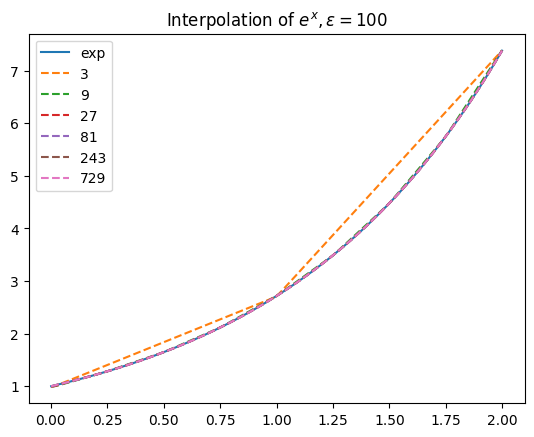

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(verification_data['x'], verification_data['y'], label = 'exp')
file_path = f'training_performance_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}/{file_path}{N}_eps{eps}.csv')
    plt.plot(df['x'], df['interpolation'], label = N, linestyle='--')
plt.legend()
plt.title(f'Interpolation of $e^x, \epsilon={eps}$')
plt.show()

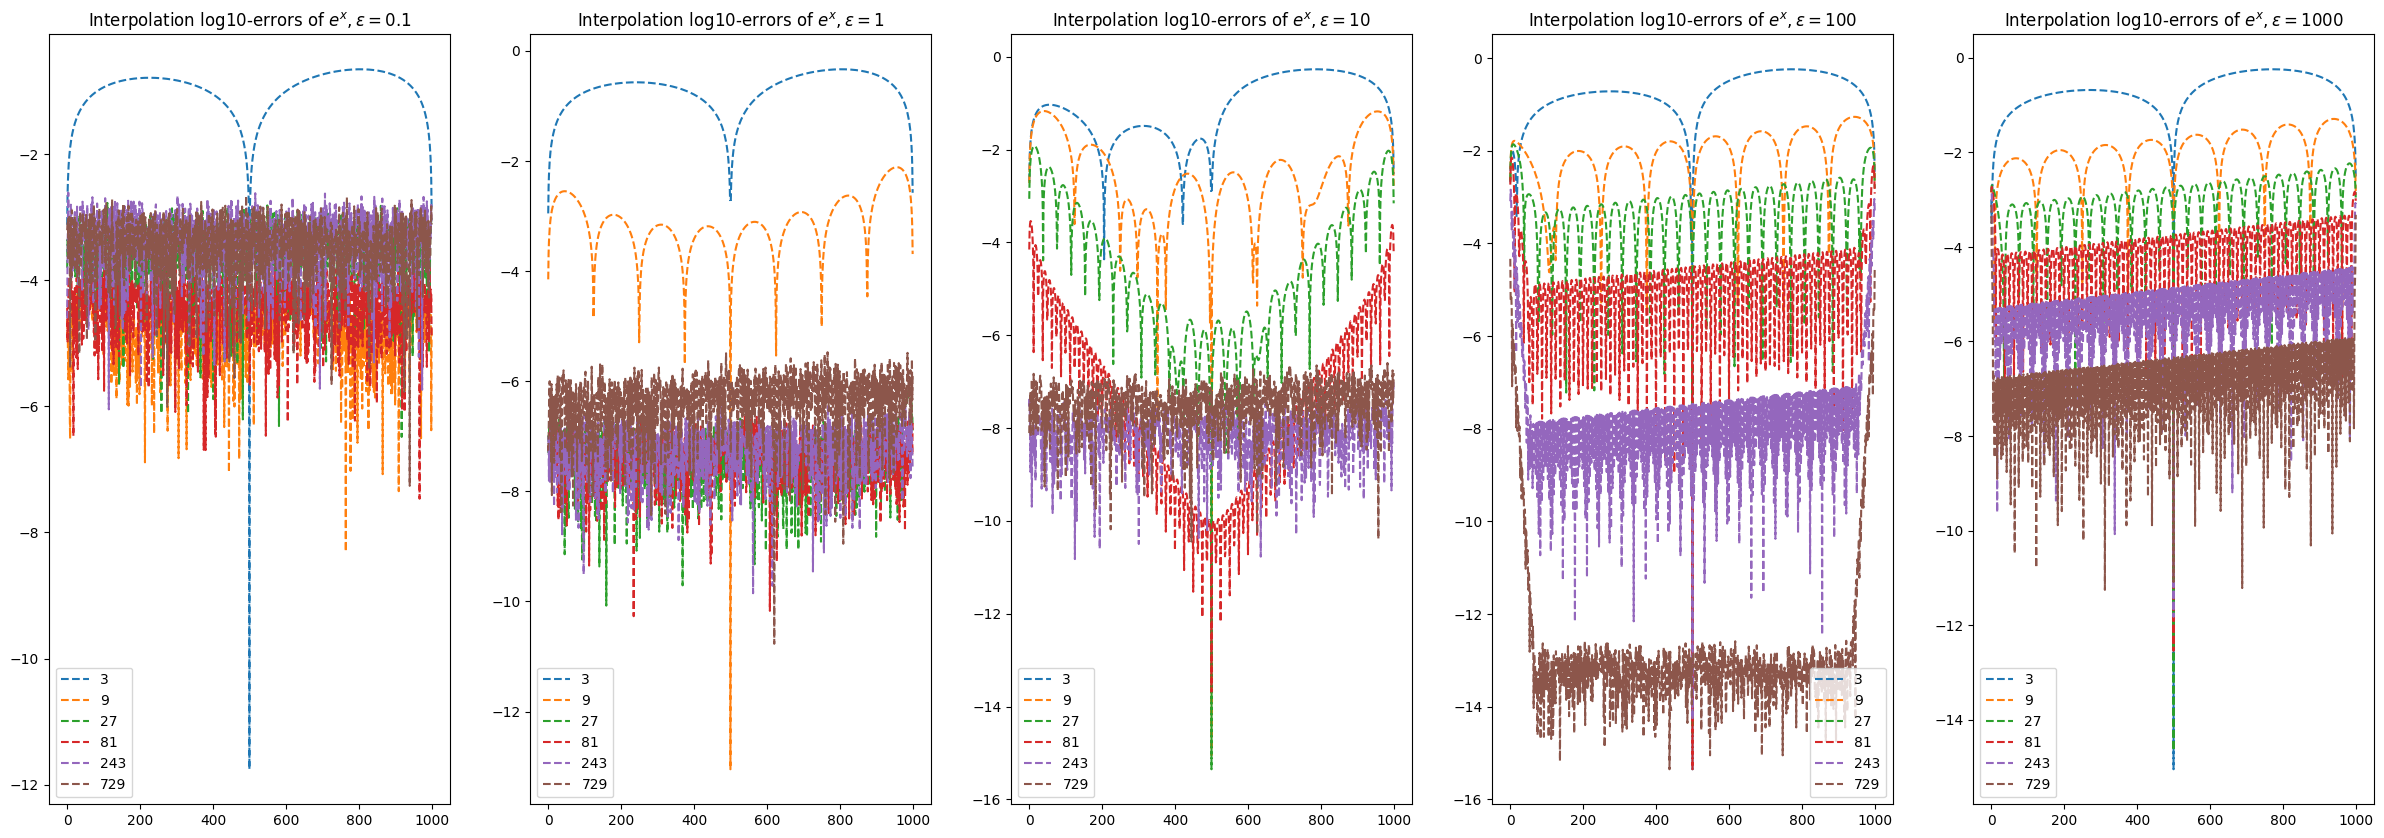

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

file_path = f'training_performance_{interpolating_for}_input'
eps_list = [0.1, 1, 10, 100, 1000]
with np.errstate(divide='ignore'): # ignore cases when division by zero appears
    fig, axes = plt.subplots(nrows = 1, ncols = len(eps_list), figsize = (30, 10))
    for eps_idx in range(len(eps_list)):
        for N in n_inputs:
            df = pd.read_csv(f'{results_path}/{file_path}{N}_eps{eps_list[eps_idx]}.csv')
            axes[eps_idx].plot(np.log10(np.abs(df['y_target'].to_numpy() - df['interpolation'].to_numpy())), label = N, linestyle='--')
        axes[eps_idx].legend()
        axes[eps_idx].set_title(f'Interpolation log10-errors of $e^x, \epsilon={eps_list[eps_idx]}$')